<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification3/Custom_CNN_HybridDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [35]:
# Define dataset directory
DATASET_DIRECTORY = 'Augmented_Refined_Hybrid_Dataset2'

# Image size & batch size
image_size = (48, 48)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT  # Splitting training data
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data (80%)
train_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"  # 80% for training
)

# Load Validation Data (20%)
val_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"  # 20% for validation
)

# Load Test Data (Untouched)
test_data = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "test"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False  # Keep order unchanged for evaluation
)

# Print dataset details
print(f"Training samples: {train_data.samples}, Classes: {train_data.num_classes}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")

Found 31360 images belonging to 7 classes.
Found 7833 images belonging to 7 classes.
Found 4557 images belonging to 7 classes.
Training samples: 31360, Classes: 7
Validation samples: 7833
Test samples: 4557


In [36]:
def count_images_in_file(directory):
    counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            counts[subdir] = sum(1 for file in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, file)))

    df = pd.DataFrame(counts, index=['Counts'])
    return df

train_count = count_images_in_file('Augmented_Refined_Hybrid_Dataset2/train')
test_count = count_images_in_file('Augmented_Refined_Hybrid_Dataset2/test')

print(train_count)
print(test_count)

        angry  disgust  fear  happy  neutral   sad  surprise
Counts   5599     5599  5599   5599     5599  5599      5599
        angry  disgust  fear  happy  neutral  sad  surprise
Counts    651      651   651    651      651  651       651


<Axes: >

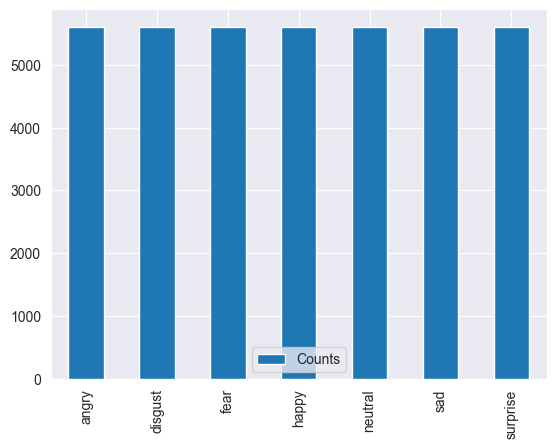

In [37]:
train_count.transpose().plot(kind='bar')

<Axes: >

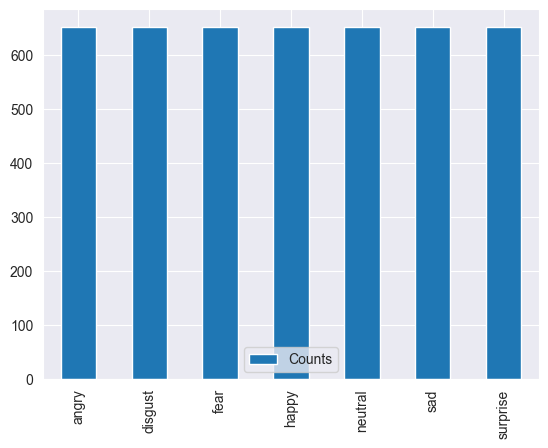

In [38]:
test_count.transpose().plot(kind='bar')

In [39]:
# Define the model with residual connections
inputs = Input(shape=(48, 48, 1))

# First Conv block with larger kernel
x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
residual = x  # Save for skip connection
x = MaxPooling2D(2, 2)(x)  # 48x48 -> 24x24
x = Dropout(0.2)(x)

# Second Conv block with residual connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
# Adjust residual to match dimensions (if needed, add a 1x1 conv or pooling)
residual = Conv2D(128, (1, 1), activation='relu', padding='same')(MaxPooling2D(2, 2)(residual))  # 48x48 -> 24x24
x = Add()([x, residual])  # Residual connection
x = MaxPooling2D(2, 2)(x)  # 24x24 -> 12x12
x = Dropout(0.3)(x)

# Third Conv block
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(7, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 48, 48,    │      1,664 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 24, 24,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │     73,856 │ dropout_19[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 24, 24,    │      8,320 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 12, 12,    │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 12, 12,    │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 12, 12,    │    295,168 │ dropout_20[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 36864)     │          0 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  9,437,440 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,853,575 (37.59 MB)

 Trainable params: 9,851,911 (37.58 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [40]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=5,                # Allow 5 epochs of no improvement
    restore_best_weights=True, # Restore the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',    # Monitor validation accuracy
    factor=0.5,                # Reduce the learning rate by half
    patience=3,                # Wait for 3 epochs of no improvement
    min_lr=1e-6,               # Lower bound for the learning rate
    verbose=1                  # Print a message when the learning rate is reduced
)

checkpoint = ModelCheckpoint(
    'best_model.keras',           # File to save the best model
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the best model
    mode='max',                # Maximize val_accuracy
    verbose=1
)

In [41]:
# Get the class labels assigned to each image in the training dataset
y_train = train_data.classes  # Extract labels from train_data

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format required by Keras
class_weights = dict(enumerate(class_weights))

In [42]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,  # Using validation data
    epochs=30,
    batch_size=32,             # Explicit batch size (adjust if needed)
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/30


C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2016 - loss: 11.5170
Epoch 1: val_accuracy improved from -inf to 0.19163, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 118s 236ms/step - accuracy: 0.2016 - loss: 11.5092 - val_accuracy: 0.1916 - val_loss: 4.4041 - learning_rate: 0.0010
Epoch 2/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3009 - loss: 3.9395
Epoch 2: val_accuracy improved from 0.19163 to 0.22265, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 236ms/step - accuracy: 0.3010 - loss: 3.9390 - val_accuracy: 0.2226 - val_loss: 3.7060 - learning_rate: 0.0010
Epoch 3/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.3708 - loss: 3.3552
Epoch 3: val_accuracy improved from 0.22265 to 0.27933, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 115s 235ms/step - accuracy: 0.3708 - loss: 3.3552 - val_accuracy: 0.2793 - val_loss: 3.5509 - learning_rate: 0.0010
Epoch 4/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3990 - loss: 3.2713
Epoch 4: val_accuracy improved from 0.27933 to 0.36768, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 236ms/step - accuracy: 0.3990 - loss: 3.2713 - val_accuracy: 0.3677 - val_loss: 3.4115 - learning_rate: 0.0010
Epoch 5/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4158 - loss: 3.3614
Epoch 5: val_accuracy did not improve from 0.36768
490/490 ━━━━━━━━━━━━━━━━━━━━ 115s 235ms/step - accuracy: 0.4158 - loss: 3.3615 - val_accuracy: 0.2816 - val_loss: 3.6283 - learning_rate: 0.0010
Epoch 6/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4265 - loss: 3.3432
Epoch 6: val_accuracy did not improve from 0.36768
490/490 ━━━━━━━━━━━━━━━━━━━━ 117s 238ms/step - accuracy: 0.4265 - loss: 3.3432 - val_accuracy: 0.3384 - val_loss: 3.6342 - learning_rate: 0.0010
Epoch 7/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4392 - loss: 3.2980
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy did not improve from 0.36768
490/490 ━━━━━━━━━━━━━━━━━━━━ 118s 241ms/step - accuracy: 0.4392 - loss:

490/490 ━━━━━━━━━━━━━━━━━━━━ 121s 246ms/step - accuracy: 0.4740 - loss: 2.7260 - val_accuracy: 0.4069 - val_loss: 2.8837 - learning_rate: 5.0000e-04
Epoch 9/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4983 - loss: 2.6259
Epoch 9: val_accuracy improved from 0.40687 to 0.44491, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 117s 239ms/step - accuracy: 0.4983 - loss: 2.6258 - val_accuracy: 0.4449 - val_loss: 2.7114 - learning_rate: 5.0000e-04
Epoch 10/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4961 - loss: 2.5798
Epoch 10: val_accuracy improved from 0.44491 to 0.45449, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 237ms/step - accuracy: 0.4961 - loss: 2.5799 - val_accuracy: 0.4545 - val_loss: 2.6411 - learning_rate: 5.0000e-04
Epoch 11/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5091 - loss: 2.5805
Epoch 11: val_accuracy did not improve from 0.45449
490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 236ms/step - accuracy: 0.5091 - loss: 2.5805 - val_accuracy: 0.4387 - val_loss: 2.7359 - learning_rate: 5.0000e-04
Epoch 12/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5128 - loss: 2.6095
Epoch 12: val_accuracy improved from 0.45449 to 0.46496, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 117s 239ms/step - accuracy: 0.5128 - loss: 2.6095 - val_accuracy: 0.4650 - val_loss: 2.6659 - learning_rate: 5.0000e-04
Epoch 13/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5207 - loss: 2.5649
Epoch 13: val_accuracy improved from 0.46496 to 0.47032, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 236ms/step - accuracy: 0.5207 - loss: 2.5650 - val_accuracy: 0.4703 - val_loss: 2.6251 - learning_rate: 5.0000e-04
Epoch 14/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5291 - loss: 2.5370
Epoch 14: val_accuracy improved from 0.47032 to 0.47632, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 237ms/step - accuracy: 0.5290 - loss: 2.5370 - val_accuracy: 0.4763 - val_loss: 2.6075 - learning_rate: 5.0000e-04
Epoch 15/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5259 - loss: 2.5252
Epoch 15: val_accuracy did not improve from 0.47632
490/490 ━━━━━━━━━━━━━━━━━━━━ 116s 237ms/step - accuracy: 0.5259 - loss: 2.5252 - val_accuracy: 0.3942 - val_loss: 2.7998 - learning_rate: 5.0000e-04
Epoch 16/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5349 - loss: 2.5410
Epoch 16: val_accuracy did not improve from 0.47632
490/490 ━━━━━━━━━━━━━━━━━━━━ 117s 239ms/step - accuracy: 0.5349 - loss: 2.5410 - val_accuracy: 0.4581 - val_loss: 2.6813 - learning_rate: 5.0000e-04
Epoch 17/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5425 - loss: 2.4875
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_accuracy did not improve from 0.47632
490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 242ms/step - accur

490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 243ms/step - accuracy: 0.5689 - loss: 2.1700 - val_accuracy: 0.5057 - val_loss: 2.1833 - learning_rate: 2.5000e-04
Epoch 19/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5810 - loss: 2.0205
Epoch 19: val_accuracy did not improve from 0.50568
490/490 ━━━━━━━━━━━━━━━━━━━━ 118s 241ms/step - accuracy: 0.5810 - loss: 2.0205 - val_accuracy: 0.4587 - val_loss: 2.4002 - learning_rate: 2.5000e-04
Epoch 20/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5808 - loss: 2.0244
Epoch 20: val_accuracy did not improve from 0.50568
490/490 ━━━━━━━━━━━━━━━━━━━━ 121s 246ms/step - accuracy: 0.5808 - loss: 2.0245 - val_accuracy: 0.4744 - val_loss: 2.3265 - learning_rate: 2.5000e-04
Epoch 21/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5911 - loss: 2.0291
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 21: val_accuracy did not improve from 0.50568
490/490 ━━━━━━━━━━━━━━━━━━━━ 120s 245ms/step - accur

490/490 ━━━━━━━━━━━━━━━━━━━━ 139s 283ms/step - accuracy: 0.6230 - loss: 1.6819 - val_accuracy: 0.5228 - val_loss: 1.9758 - learning_rate: 1.2500e-04
Epoch 24/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.6415 - loss: 1.6797
Epoch 24: val_accuracy improved from 0.52279 to 0.54270, saving model to best_model.h5


490/490 ━━━━━━━━━━━━━━━━━━━━ 131s 266ms/step - accuracy: 0.6414 - loss: 1.6798 - val_accuracy: 0.5427 - val_loss: 1.9707 - learning_rate: 1.2500e-04
Epoch 25/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6456 - loss: 1.7015
Epoch 25: val_accuracy did not improve from 0.54270
490/490 ━━━━━━━━━━━━━━━━━━━━ 125s 255ms/step - accuracy: 0.6455 - loss: 1.7016 - val_accuracy: 0.5348 - val_loss: 2.0286 - learning_rate: 1.2500e-04
Epoch 26/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6496 - loss: 1.7330
Epoch 26: val_accuracy did not improve from 0.54270
490/490 ━━━━━━━━━━━━━━━━━━━━ 127s 260ms/step - accuracy: 0.6496 - loss: 1.7331 - val_accuracy: 0.5160 - val_loss: 2.0684 - learning_rate: 1.2500e-04
Epoch 27/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6639 - loss: 1.7170
Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 27: val_accuracy did not improve from 0.54270
490/490 ━━━━━━━━━━━━━━━━━━━━ 120s 245ms/step - accura

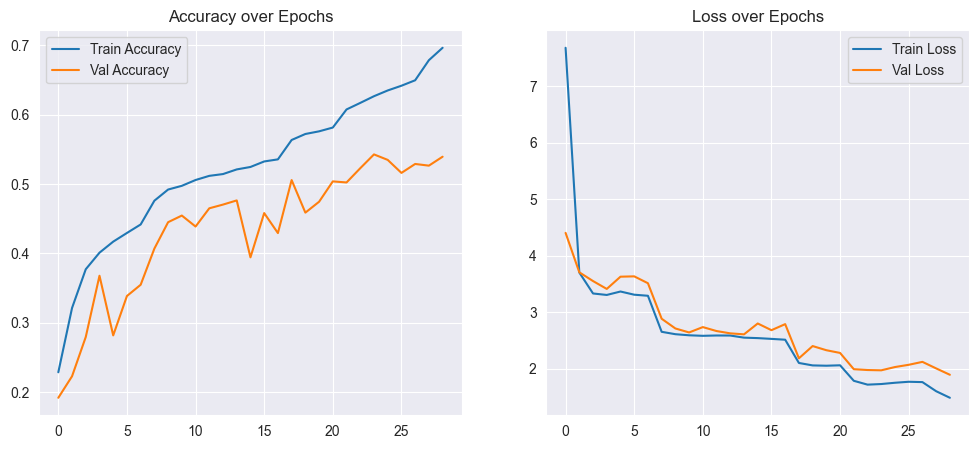

In [43]:
# Plotting Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


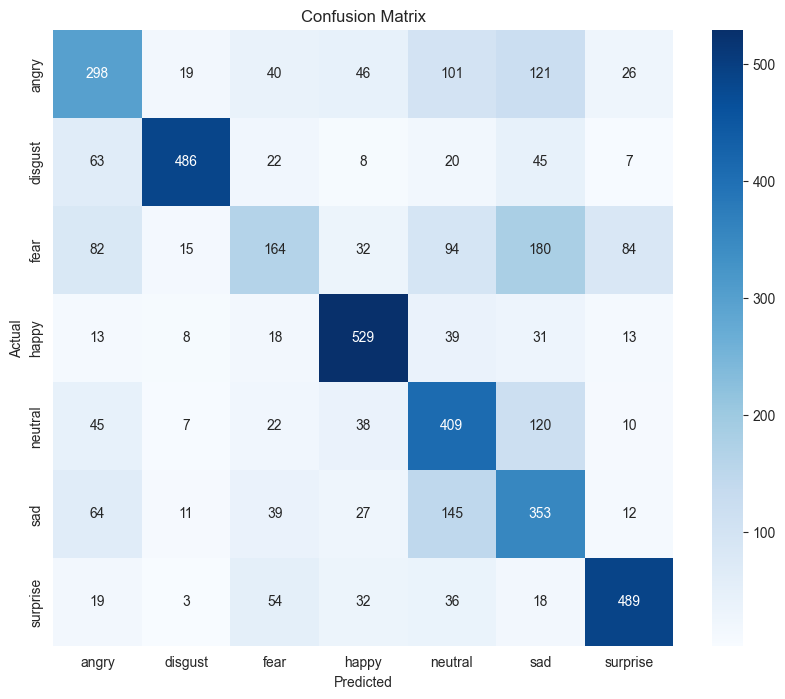

In [44]:
# Predict on validation data (test_data)
y_pred = model.predict(test_data)  # Using test_data (ImageDataGenerator for validation)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test_data (using the flow_from_directory)
y_true_classes = test_data.classes  # Extract true labels from the 'classes' attribute of the generator

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=test_data.class_indices.keys(),  # Using class labels from the generator
            yticklabels=test_data.class_indices.keys())  # Using class labels from the generator
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [45]:
from sklearn.metrics import classification_report

# Get predictions
y_pred_prob = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true_classes = test_data.classes  # Extract true labels
class_labels = list(test_data.class_indices.keys())  # Get class names

# Generate Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
              precision    recall  f1-score   support

       angry       0.51      0.46      0.48       651
     disgust       0.89      0.75      0.81       651
        fear       0.46      0.25      0.32       651
       happy       0.74      0.81      0.78       651
     neutral       0.48      0.63      0.55       651
         sad       0.41      0.54      0.46       651
    surprise       0.76      0.75      0.76       651

    accuracy                           0.60      4557
   macro avg       0.61      0.60      0.59      4557
weighted avg       0.61      0.60      0.59      4557



In [46]:
model.save("custom_model_v3.keras")

In [47]:
import cv2
# Load the trained model
model = tf.keras.models.load_model("custom_model_v3.keras")

# Define the categories
focused_classes = ["Happy", "Neutral", "Surprise"]
unfocused_classes = ["Angry", "Disgust", "Fear", "Sad"]

# Define the image directory
image_folder = "Student_live_captures"  # Folder containing the 50 images

# Emotion class labels (update based on your dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Initialize counters
focused_count = 0
unfocused_count = 0
total_images = 0

# Process each image in the folder
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)

    # Read and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (48, 48))  # Resize to match input shape
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]  # Get the highest probability class

    # Categorize into Focused or Unfocused
    if predicted_class in focused_classes:
        focused_count += 1
    else:
        unfocused_count += 1

    total_images += 1

# Compute the ratio
focused_ratio = focused_count / total_images
unfocused_ratio = unfocused_count / total_images

# Display results
print(f"Total Images: {total_images}")
print(f"Focused Count: {focused_count}")
print(f"Unfocused Count: {unfocused_count}")
print(f"Focused:Unfocused Ratio -> {focused_ratio:.2f} : {unfocused_ratio:.2f}")


ValueError: File not found: filepath=custom_model_50epoch.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("custom_model_v3.keras")  # Update with your model path

# Define the image folder
image_folder = "Student_live_captures"  # Folder containing images

# Emotion class labels (update based on dataset order)
class_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Get a list of image file names
image_files = os.listdir(image_folder)

# Choose a subset of images to display (adjust number if needed)
num_images_to_display = min(25, len(image_files))  # Display up to 25 images
selected_images = np.random.choice(image_files, num_images_to_display, replace=False)

# Set up plot grid
cols = 5  # Number of columns in the grid
rows = num_images_to_display // cols + (num_images_to_display % cols > 0)  # Auto-calculate rows

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()  # Flatten in case of excess subplots

# Process and display images
for i, img_name in enumerate(selected_images):
    img_path = os.path.join(image_folder, img_name)

    # Read and preprocess image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    img_resized = cv2.resize(img, (48, 48))  # Resize to match input shape
    img_array = img_resized / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]  # Get highest probability class

    # Display image with prediction
    axes[i].imshow(img_resized, cmap="gray")
    axes[i].set_title(predicted_class, fontsize=12, color="red")
    axes[i].axis("off")  # Hide axes

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Show the plot
plt.tight_layout()
plt.show()